In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])
movies = pd.read_csv("ml-100k/u.item", sep="|", names=["movie_id", "movie_title"], usecols=[0,1], encoding="latin-1")

In [122]:
print(ratings.head())

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


In [ ]:
print(movies.head())

In [20]:
total_df = ratings.merge(movies, on ="movie_id")

In [116]:
print(total_df.head())

   user_id  movie_id  rating  timestamp                 movie_title
0      196       242       3  881250949                Kolya (1996)
1      186       302       3  891717742    L.A. Confidential (1997)
2       22       377       1  878887116         Heavyweights (1994)
3      244        51       2  880606923  Legends of the Fall (1994)
4      166       346       1  886397596         Jackie Brown (1997)


In [ ]:
sns.countplot(x="rating", data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [117]:
print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}")

Mean global rating: 3.53


In [ ]:
mean_ratings = ratings.groupby("user_id")["rating"].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}")

In [79]:
total_df["movie_title"].value_counts()[0:5]

movie_title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: count, dtype: int64

In [ ]:
mean_ratings = ratings.groupby("movie_id")["rating"].mean()
lowest_rated_movies = mean_ratings.nsmallest(1)
lowest_movie_id = lowest_rated_movies.index[0]
print(f"Lowest rated movie: {movies[movies['movie_id'] == lowest_movie_id]['movie_title'].values[0]} with a rating of {lowest_rated_movies.values[0]}")

In [ ]:
highest_rated_movie = mean_ratings.nlargest(1)
highest_rated_movie_id = highest_rated_movie.index[0]
print(f"Highest rated movie: {movies[movies['movie_id'] == highest_rated_movie_id]['movie_title'].values[0]} with a rating of {highest_rated_movie.values[0]}")

In [ ]:
movie_stats = ratings.groupby("movie_id")["rating"].agg(["count", "mean"])
C = movie_stats["count"].mean()
m = movie_stats["mean"].mean()

print(f"The average number of ratings per movie is: {C:.2f}")
print(f"The average rating for a given movie is {m:.2f}")

In [76]:
def bayesian_average(ratings):
    bayesian_average = (C * m + ratings.sum()) / (C + ratings.count())
    return round(bayesian_average, 3)

In [77]:
bayesian_avg_ratings = ratings.groupby("movie_id")["rating"].agg(bayesian_average).reset_index()
bayesian_avg_ratings.columns = ["movie_id", "bayesian_average"]
movie_stats = movie_stats.merge(bayesian_avg_ratings, on="movie_id")

In [ ]:
movie_stats.head()

In [ ]:
movie_stats = movie_stats.merge(movies[["movie_id", "movie_title"]])
movie_stats.sort_values(by="bayesian_average", ascending=False)

In [ ]:
movie_stats.sort_values(by="bayesian_average", ascending=True)

In [ ]:
movie_genres = pd.read_csv("ml-100k/u.genre", sep="|", names=["genre", "genre_id"])
movies_with_genres = pd.read_csv("ml-100k/u.item", sep="|", names=["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"], encoding="latin-1")


In [148]:
from scipy.sparse import csr_matrix

def create_X(df):
    """ Generates a sparse matrix from ratings dataframe

    Args: 
        df: pandas dataframe containing 3 columns (user_id, movie_id, rating)

    Returns:
        x: sparse Matrix
        user_mapper: dictionary mapping user_id to user indices
        user_inv_mapper: dictionary mapping user indices to user_id
        movie_mapper: dictionary mapping movie_id to movie indices
        movie_inv_mapper: dictionary mapping movie indices to movie_id
    """

    num_users = df["user_id"].nunique()
    num_movies = df["movie_id"].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(num_users))))
    movie_mapper = dict(zip(np.unique(df["movie_id"]), list(range(num_movies))))

    user_inv_mapper = dict(zip(list(range(num_users)), np.unique(df["user_id"])))
    movie_inv_mapper = dict(zip(list(range(num_movies)), np.unique(df["movie_id"])))

    user_index = [user_mapper[i] for i in df["user_id"]]
    item_index = [movie_mapper[i] for i in df["movie_id"]]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(num_users, num_movies))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [141]:
X.shape

(943, 1682)

In [149]:
total_cells = X.shape[0] * X.shape[1]
total_ratings = X.nnz # number of non-zero entries
sparsity = total_ratings / total_cells
print(f"Matrix Sparsity: {round(sparsity*(100),2)}%")

Matrix Sparsity: 6.3%


In [150]:
total_ratings_per_user = X.getnnz(axis=1)
len(total_ratings_per_user)

943

In [ ]:
print(f"Most active user rated {total_ratings_per_user.max()} ratings")
print(f"Least active user rated {total_ratings_per_user.min()} ratings")

Most active user rated 737 ratings
Least active user rated 20 ratings


In [139]:
total_ratings_per_movie = X.getnnz(axis=0)
len(total_ratings_per_movie)

1682

In [142]:
print(f"Most rated movie received {total_ratings_per_movie.max()} ratings")
print(f"Least rated movie received {total_ratings_per_movie.min()} ratings")

Most rated movie received 583 ratings
Least rated movie received 1 ratings


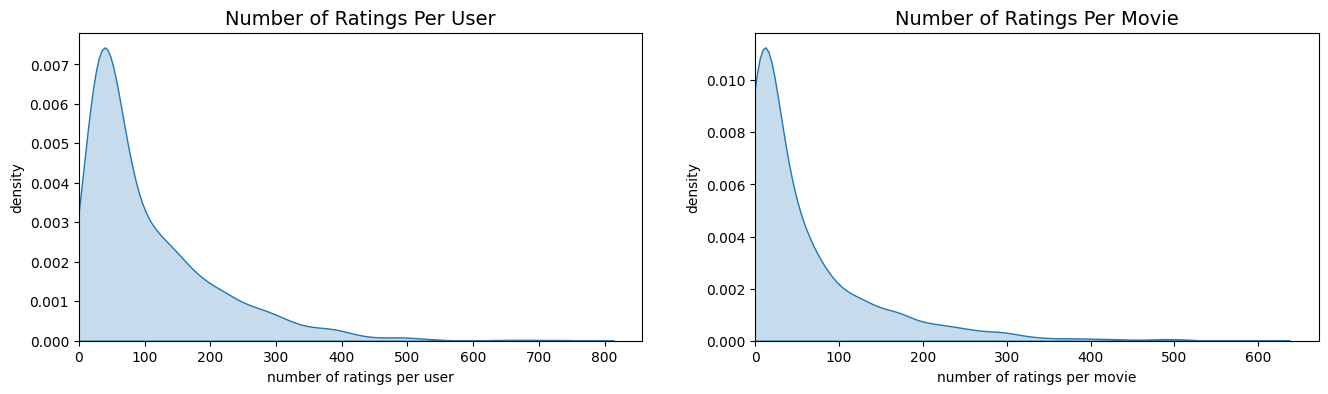

In [145]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(total_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(total_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

Up to this point we are now confident after looking at all the other datapoints that we can continue with collaborative filtering
The data is sparse but not sparse enough

In [153]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric="cosine"):

    """ 
    Find k-nearest neighbors for a given movie_id.

    Args: 
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve 
        metric: distance metric for kNN calculations

    Returns: returns list of k similar movie IDs
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [154]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[np.int64(50),
 np.int64(181),
 np.int64(121),
 np.int64(117),
 np.int64(405),
 np.int64(151),
 np.int64(222),
 np.int64(100),
 np.int64(237)]

In [176]:
movie_titles = dict(zip(movies["movie_id"], movies["movie_title"]))
movie_id = 1682

try:
    similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric="cosine")
    movie_title = movie_titles[movie_id]

    print(f"Because you watched {movie_title}:")
    for i in similar_movies:
        print(movie_titles[i])

except Exception:
    print("Keep movie_id between 1 and 1682 please!")


Because you watched Scream of Stone (Schrei aus Stein) (1991):
Addiction, The (1995)
American Buffalo (1996)
Romper Stomper (1992)
Stalingrad (1993)
Farinelli: il castrato (1994)
Bitter Moon (1992)
Mrs. Parker and the Vicious Circle (1994)
SubUrbia (1997)
Naked (1993)
